Let's import everything at the begining (My past as a C/C++ programmer betrays me)

In [1]:
import numpy as np
import pylab as plt
import pandas as pd
import multiprocessing
from scipy.misc import imread
from random import shuffle
import data_augmentation_toolkit as data_aug
import random
import os
%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

Using TensorFlow backend.


Create an initial model. I don't agree to much with the idea of doing subsampling (stride>1) in the convolutional layers, as I read in multiple places that is more destructive than using a pooling layer after the convolutional one without subsampling, but let's give it an oportunity.

In [3]:
def get_model_nvidia(image_shape):
    """
    End to End Learning for Self-Driving Cars
    http://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf
    
    No info is provided for activations, hence I choose RELU
    """
    

    '''
    def normalize(x, a, b):
        x = x.astype(np.float32)
        return a + (x-x.min())*(b-a)/(x.max() - x.min())
    '''
    
    model = Sequential()
    
    # Use a lambda layer to normalize the input data
    #model.add(Lambda(lambda x: normalize(x, 0, 1), input_shape=image_shape, output_shape=image_shape))
    # Removed Lambda layer. Seems to add more troubles than it helps.
    model.add(Convolution2D(nb_filter=24, nb_row=5, nb_col=5, border_mode='valid', subsample=(2,2), input_shape=image_shape))
    model.add(Activation('relu'))
    model.add(Convolution2D(nb_filter=36, nb_row=5, nb_col=5, border_mode='valid', subsample=(2,2)))
    model.add(Activation('relu'))
    model.add(Convolution2D(nb_filter=48, nb_row=5, nb_col=5, border_mode='valid', subsample=(2,2)))
    model.add(Activation('relu'))
    model.add(Convolution2D(nb_filter=64, nb_row=3, nb_col=3, border_mode='valid'))
    model.add(Activation('relu'))
    model.add(Convolution2D(nb_filter=64, nb_row=3, nb_col=3, border_mode='valid'))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(1164))
    model.add(Activation('relu'))     
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dense(50))
    model.add(Activation('relu'))
    model.add(Dense(10))
    model.add(Activation('relu'))
    model.add(Dense(1))
    
    return model

Maybe I want to play with optimizers later, but for the moment, a standard adam should be more than fine

In [4]:
def get_optimizer():
    return Adam()

In [5]:
path2models = "./models/model.{epoch:02d}-{val_loss:.2f}.h5"

os.makedirs('./models', exist_ok=True)


def train_model(train_gen, val_gen, batch_size, epochs, model, \
                optimizer=None, limit_train=None, limit_val=None):
    
    if optimizer:
        model.compile(optimizer=optimizer, loss="mse")
    else:
        model.compile(optimizer="adam", loss="mse") # This is a nice optimizer to be left as default
        
    # Callbacks
    reduce_lr_on_plateau = ReduceLROnPlateau(factor=0.5, patience=3, cooldown=3, min_lr=1e-5)
    checkpoint = ModelCheckpoint(filepath=path2models)
    early_stopping = EarlyStopping(min_delta=2*1e-3, patience=7)
    
    ls_callbacks = [checkpoint, reduce_lr_on_plateau, early_stopping]
    
        
    samples_per_epoch = limit_train if limit_train else train_gen.get_epoch_size()
    nb_epoch = epochs
    nb_val_samples = limit_val if limit_val else val_gen.get_epoch_size()
    history = model.fit_generator(train_gen, samples_per_epoch, nb_epoch, \
                                  nb_val_samples=nb_val_samples, validation_data=val_gen, callbacks=ls_callbacks)
    
    return history, model

In [19]:
# Prepare the data with a python generator so we can do data augmentation on the fly

class My_dataset_gen():
    """
    To be strict, My_dataset_gen is not a real generator (does not call yield) but an iterator
    """
    def __init__(self, 
                 path2csv,
                 batch_size,
                 crop_input,
                 training=True):
        
        self.batch_size = batch_size
        self.crop_input = crop_input
        
        # Load the CSV
        self.path2csv = path2csv
        df = pd.read_csv(self.path2csv)
        self.dataset = df.to_dict(orient='records') # This is a list of dict
        
        self.position = 0
        self.size_epoch = len(self.dataset)
        self.training = training
        
        # Angle-preserving transformations
        self.angle_preserving = [data_aug.salt_and_pepper, data_aug.bilateral_filter, data_aug.speckle_noise, data_aug.random_light, data_aug.random_shadow, data_aug.identity]
        
    def __iter__(self):
        return self
    
    def __next__(self):

        number_of_samples = 0
        X_l = list()
        Y_l = list()
        
        while number_of_samples < self.batch_size:
            if self.position == self.size_epoch:
                shuffle(self.dataset)
                self.position = 0
                
            sample = self.dataset[self.position]
            
            rand_val = random.random()
            
            if not self.training or rand_val <= 1-sample['Probability appearance']: # This way we eliminate biases toward more frequent values
                # E.g. sample['Probability appearance'] = 0.25. This means it appears  only 25% of the times in the dataset
                # but I want to balance it, so I do 1-0.25= 0.75. Comparing with a random value between 0 and 1, this sample 
                # will be used (with data augmentation techniques) the 75% of the times. Category samples with a high 
                # 'Probability appearance' will be more likely rejected, but because of there are more samples of that 
                # category doesn't matter. On average all categories should be balanced.
                image = imread(sample['Updated image path'])
                image = self._crop(image)
                angle = sample['Steering angle']
                
                if self.training:
                    image, angle = self._random_transform(image, angle)
                    
                image = self._normalize(image)
                
                X_l.append(image)
                Y_l.append(angle)
                
                number_of_samples += 1
                
            self.position += 1
            
            
        X = np.array(X_l) # Current shape follows tf dim_ordering: (samples, height, width, channels)
        Y = np.array(Y_l)
        
        return (X,Y)
            
    
    def _normalize(self, x, a=0, b=1):
        x = x.astype(np.float32)
        return a + (x-x.min())*(b-a)/(x.max() - x.min())
    
    def _crop(self, x):
            return x[50:150, :] # See Explore dataset + Experimental setup.ipynb

    def _random_transform(self, image, angle):
        # We are always going to choose a random angle-preserving transformation (the identity is included) and
        # after that a non-angle-preserving transformation the half of the time.
        
        # Angle-preserving transformation
        image = random.choice(self.angle_preserving)(image)
        
        # Non-angle-preserving transformation
        
        if random.random() >= 0.5:
            image = data_aug.horizontal_flipping(image)
            angle = -angle
            
        return image, angle
    
    def get_image_shape(self):
        
        temp = imread(self.dataset[0]['Updated image path'])
        
        if self.crop_input:
            return self._crop(temp).shape
        else:
            return temp.shape
        
    def get_epoch_size(self):
        return self.size_epoch

# Let's perform a quick test to see if all the pieces work

In [20]:
path2dataset = "/mnt/Behavioral-Cloning-Dataset/"
path2csv_training = path2dataset + "driving_log_training.csv"
path2csv_validation = path2dataset + "driving_log_validation.csv"

batch_size = 2
epochs = 2
limit_train = 10
limit_val = 10

train_gen = My_dataset_gen(path2csv_training, batch_size, crop_input=True)
val_gen = My_dataset_gen(path2csv_validation, batch_size, crop_input=True, training=False)

In [15]:
# Let's visualize some statistics about the dataset

print("Number of training samples: %d" % (train_gen.get_epoch_size()))
print("Number of validation samples: %d" % (val_gen.get_epoch_size()))
print("Shape of the images: ", train_gen.get_image_shape())

Number of training samples: 26050
Number of validation samples: 6513
Shape of the images:  (100, 320, 3)


In [9]:
model = get_model_nvidia(train_gen.get_image_shape())
optimizer = get_optimizer()

# Just have a look at our model before training:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 48, 158, 24)   1824        convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 48, 158, 24)   0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 22, 77, 36)    21636       activation_1[0][0]               
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 22, 77, 36)    0           convolution2d_2[0][0]            
___________________________________________________________________________________________

In [21]:
history, model = train_model(train_gen, val_gen, batch_size, epochs, model, optimizer, limit_train, limit_val)
# There is no need to save the model. It's already saved by the callbacks provided in fit_generator

Epoch 1/2
10/10 [==============================] - 4s - loss: 0.0432 - val_loss: 0.0399
Epoch 2/2
10/10 [==============================] - 1s - loss: 0.0043 - val_loss: 0.0102


In [22]:
def plot_loss_vs_epochs(training_loss, validation_loss):
    plt.plot(range(1,len(training_loss)+1), training_loss, 'b')
    plt.xticks(range(1,len(training_loss)+1))
    plt.hold(True)
    plt.plot(range(1,len(training_loss)+1), validation_loss, 'g')
    plt.hold(False)
    _ = plt.legend(("Training", "Validation"), loc='lower right')
    _ = plt.ylabel("Loss")
    _ = plt.xlabel("Epochs")

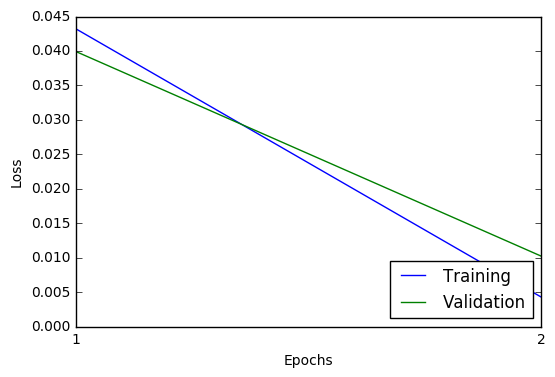

In [23]:
plot_loss_vs_epochs(history.history['loss'], history.history['val_loss'])

# Let's do the real training

In [ ]:
batch_size = 64
epochs = 10

In [ ]:
train_gen = My_dataset_gen(path2csv_training, batch_size, crop_input=True)
val_gen = My_dataset_gen(path2csv_validation, batch_size, crop_input=True, training=False)

model = get_model_nvidia(train_gen.get_image_shape())
optimizer = get_optimizer()

In [ ]:
history, model = train_model(train_gen, val_gen, batch_size, epochs, model, optimizer)
# There is no need to save the model. It's already saved by the callbacks provided in fit_generator

In [ ]:
plot_loss_vs_epochs(history.history['loss'], history.history['val_loss'])